__Forecasting__

- Build sequences (input windows).
- Train baselines (naive, EWMA).
- Train LSTM/GRU
- Stability: Try walk‑forward validation to ensure the improvement holds across different time periods/regimes.???
- Explore PCA in choosing key features
- Explore with and without unsupervised learning approach

In [84]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras import layers, models
import keras_tuner as kt
import matplotlib.pyplot as plt

__Load parquet with aggregated features and regimes__

In [46]:
regimes_df = pd.read_parquet("daily_features_with_regimes.parquet") 
regimes_df.head()

,date,ATM_IV,Skew,Curvature,treasury_2y,ticker,year,Regime_K
0,2022-01-03,0.168059,0.062764,0.009883,0.78,QQQ,2022,1
1,2022-01-04,0.176395,0.093166,0.037454,0.77,QQQ,2022,0
2,2022-01-05,0.234323,0.090518,0.009621,0.83,QQQ,2022,0
3,2022-01-06,0.221465,0.096028,0.018208,0.88,QQQ,2022,0
4,2022-01-07,0.228680,0.092189,0.008344,0.87,QQQ,2022,0


Normalizing the features so that ATM_IV, Skew, Curvature, and dgs2 are on comparable scales. This reduces bias toward large‑magnitude variables and stabilizes training.

In [47]:
# Preserve original ATM_IV for target scaling
regimes_df['ATM_IV_orig'] = regimes_df['ATM_IV']

In [48]:
# 1. Feature scaler
feature_scaler_cols = ['ATM_IV','Skew','Curvature','treasury_2y']

feature_scaler = StandardScaler()
regimes_df[feature_scaler_cols] = feature_scaler.fit_transform(regimes_df[feature_scaler_cols])

# 2. Target scaler (ATM_IV only)
target_scaler = StandardScaler()
regimes_df['ATM_IV_target'] = target_scaler.fit_transform(
    regimes_df[['ATM_IV_orig']]
)

In [49]:
regimes_df.head()

,date,ATM_IV,Skew,Curvature,treasury_2y,ticker,year,Regime_K,ATM_IV_orig,ATM_IV_target
0,2022-01-03,-1.007574,-0.014563,0.568579,-2.445619,QQQ,2022,1,0.168059,-1.007574
1,2022-01-04,-0.866825,1.395650,4.260985,-2.454372,QQQ,2022,0,0.176395,-0.866825
2,2022-01-05,0.111258,1.272821,0.533491,-2.401854,QQQ,2022,0,0.234323,0.111258
3,2022-01-06,-0.105842,1.528406,1.683493,-2.358089,QQQ,2022,0,0.221465,-0.105842
4,2022-01-07,0.015979,1.350331,0.362404,-2.366842,QQQ,2022,0,0.228680,0.015979


Since Regime_K is a categorical state label with no natural ordering, it’s better to one‑hot encode it before feeding into the model, rather than keeping it as a raw integer.

In [50]:
# One-hot encode Regime_K
regimes_df = pd.get_dummies(regimes_df, columns=['Regime_K'], prefix='Regime')
regimes_df[['Regime_0','Regime_1','Regime_2']] = \
    regimes_df[['Regime_0','Regime_1','Regime_2']].astype(int)

In [51]:
regimes_df.head()

,date,ATM_IV,Skew,Curvature,treasury_2y,ticker,year,ATM_IV_orig,ATM_IV_target,Regime_0,Regime_1,Regime_2
0,2022-01-03,-1.007574,-0.014563,0.568579,-2.445619,QQQ,2022,0.168059,-1.007574,0,1,0
1,2022-01-04,-0.866825,1.395650,4.260985,-2.454372,QQQ,2022,0.176395,-0.866825,1,0,0
2,2022-01-05,0.111258,1.272821,0.533491,-2.401854,QQQ,2022,0.234323,0.111258,1,0,0
3,2022-01-06,-0.105842,1.528406,1.683493,-2.358089,QQQ,2022,0.221465,-0.105842,1,0,0
4,2022-01-07,0.015979,1.350331,0.362404,-2.366842,QQQ,2022,0.228680,0.015979,1,0,0


In [52]:
def build_sequences(df, feature_cols, target_col='ATM_IV_target', W=60, H=3):
    """
    Build rolling input/output sequences for multi-step forecasting.
    
    Args:
        df : DataFrame with features and target
        feature_cols : list of feature column names
        target_col : str, column to forecast
        W : int, input window length
        H : int, forecast horizon (number of steps ahead)
    
    Returns:
        X : np.array, shape (N, W, F)
        y : np.array, shape (N, H)
        meta : pd.DataFrame, metadata with ticker and end_date
    """
    Xs, ys, meta = [], [], []
    
    for ticker, g in df.groupby('ticker'):
        g = g.sort_values('date').reset_index(drop=True)
        X_mat = g[feature_cols].values
        y_mat = g[target_col].values
        dates = g['date'].values
        
        for i in range(W-1, len(g)-H):
            x_win = X_mat[i-W+1:i+1]          # shape (W, F)
            y_target = y_mat[i+1:i+H+1]       # shape (H,)
            
            if np.isnan(y_target).any() or np.isnan(x_win).any():
                continue
            
            Xs.append(x_win)
            ys.append(y_target)
            meta.append({'ticker': ticker, 'end_date': dates[i]})
    
    X = np.array(Xs)
    y = np.array(ys)
    meta = pd.DataFrame(meta)
    return X, y, meta


The input is past IV, Skew, Curvature and 2 year Treasury, while the target is future IV.

In [122]:
feature_cols = ['ATM_IV','Skew','Curvature','treasury_2y'] + \
               [c for c in regimes_df.columns if c.startswith('Regime_')]

# Forecast next H days
XH, yH, metaH = build_sequences(regimes_df, feature_cols, 'ATM_IV_target', W=180, H=30)
print(XH.shape, yH.shape) 

(28, 180, 7) (28, 30)


/var/folders/g0/21_2mymx5mn788q92btxg65m0000gn/T/ipykernel_47599/3303809069.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ticker, g in df.groupby('ticker'):


__Forecast using Exponential Weighted Moving Average of the past W days as baseline__

In [129]:
def ewma_forecast(X, y, meta, alpha=0.3):
    """
    EWMA baseline: forecast next H days as the EWMA of past ATM_IV values.
    """
    H = y.shape[1]
    preds = []
    for x in X:
        iv_series = x[:, 0]  # ATM_IV is first feature
        # compute EWMA
        ewma_val = iv_series[0]
        for val in iv_series[1:]:
            ewma_val = alpha * val + (1 - alpha) * ewma_val
        preds.append(np.repeat(ewma_val, H))
    return np.array(preds)

In [131]:
y_pred_ewma = ewma_forecast(XH, yH, metaH, alpha=0.3)
print(y_pred_ewma.shape) 

(28, 30)


In [132]:
# Invert scaling for both true and predicted values
y_true_orig = target_scaler.inverse_transform(yH)
y_pred_ewma_orig  = target_scaler.inverse_transform(y_pred_ewma)

In [133]:
def evaluate_baseline(y_true, y_pred, name="baseline"):
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}")

In [134]:
# Use RMSE & MAE metrics to evaluate EWMA performance between predictions and true targets:
evaluate_baseline(y_true_orig, y_pred_ewma_orig, "EWMA")

EWMA -> RMSE: 0.0269, MAE: 0.0225


__Split time series to train, validation, and test__

In [59]:
def time_series_split(X, y, meta, train_size=0.6, val_size=0.2):
    """
    Split sequences into train/val/test by time (no shuffling).
    
    Args:
        X, y, meta : outputs from build_sequences
        train_size : fraction of data for training
        val_size   : fraction of data for validation (rest goes to test)
    
    Returns:
        (X_train, y_train, meta_train),
        (X_val, y_val, meta_val),
        (X_test, y_test, meta_test)
    """
    N = len(X)
    train_end = int(N * train_size)
    val_end   = int(N * (train_size + val_size))
    
    X_train, y_train, meta_train = X[:train_end], y[:train_end], meta.iloc[:train_end]
    X_val,   y_val,   meta_val   = X[train_end:val_end], y[train_end:val_end], meta.iloc[train_end:val_end]
    X_test,  y_test,  meta_test  = X[val_end:], y[val_end:], meta.iloc[val_end:]
    
    return (X_train, y_train, meta_train), (X_val, y_val, meta_val), (X_test, y_test, meta_test)

In [60]:
# Split into train/val/test
(X_train, y_train, meta_train), (X_val, y_val, meta_val), (X_test, y_test, meta_test) = \
    time_series_split(XH, yH, metaH)

print(X_train.shape, X_val.shape, X_test.shape)

(16, 180, 7) (6, 180, 7) (6, 180, 7)


In [61]:
def build_lstm(input_shape, H, units=64, depth=1, dropout=0.2):
    model = models.Sequential()
    # First LSTM layer
    model.add(layers.LSTM(units, return_sequences=(depth > 1), 
                          input_shape=input_shape))
    model.add(layers.Dropout(dropout))
    
    # Additional LSTM layers if depth > 1
    for _ in range(depth-1):
        model.add(layers.LSTM(units, return_sequences=False))
        model.add(layers.Dropout(dropout))
    
    # Dense output layer with H outputs (multi‑step forecast)
    model.add(layers.Dense(H))
    
    model.compile(optimizer='adam', loss='mse')
    return model

In [62]:
input_shape = (XH.shape[1], XH.shape[2])  # (W, features)
H = yH.shape[1]
lstm_model = build_lstm(input_shape, H, units=64, depth=2, dropout=0.3)

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.0344 - val_loss: 3.6610
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - loss: 0.9784 - val_loss: 3.5253
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.9171 - val_loss: 3.3940
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.8688 - val_loss: 3.2586
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.8224 - val_loss: 3.1125
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.7685 - val_loss: 2.9510
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.7076 - val_loss: 2.7691
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.6781 - val_loss: 2.5643
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - loss: 0.6186 - val_loss: 2.3371
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.5335 - val_loss: 2.0960
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.4890 - val_loss: 1.8587
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.4445 - val_loss:

In [63]:
y_pred_lstm_scaled = lstm_model.predict(X_test)
y_pred_lstm_orig = target_scaler.inverse_transform(y_pred_lstm_scaled)
y_true_lstm_orig = target_scaler.inverse_transform(y_test)

evaluate_baseline(y_true_lstm_orig, y_pred_lstm_orig, "LSTM (orig units)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
LSTM (orig units) -> RMSE: 0.0553, MAE: 0.0500


In [64]:
def build_gru(input_shape, H, units=64, depth=1, dropout=0.2):
    model = models.Sequential()
    # First GRU layer
    model.add(layers.GRU(units, return_sequences=(depth > 1), 
                         input_shape=input_shape))
    model.add(layers.Dropout(dropout))
    
    # Additional GRU layers if depth > 1
    for _ in range(depth-1):
        model.add(layers.GRU(units, return_sequences=False))
        model.add(layers.Dropout(dropout))
    
    # Dense output layer with H outputs (multi‑step forecast)
    model.add(layers.Dense(H))
    
    model.compile(optimizer='adam', loss='mse')
    return model

In [65]:
input_shape = (XH.shape[1], XH.shape[2])  # (W, features)
H = yH.shape[1]
gru_model = build_gru(input_shape, H, units=64, depth=2, dropout=0.3)

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/50


/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.2994 - val_loss: 1.1042
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3200 - val_loss: 1.1088
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.2729 - val_loss: 1.1162
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - loss: 0.3095 - val_loss: 1.1154
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.3078 - val_loss: 1.1072
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.2593 - val_loss: 1.0877
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.2676 - val_loss: 1.0595
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2274 - val_loss: 1.0221
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.2709 - val_loss: 0.9721
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.2692 - val_loss: 0.9141
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.2373 - val_loss: 0.8529
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.2574 - val_loss: 0.7930


In [66]:
y_pred_gru_scaled = gru_model.predict(X_test)
y_pred_gru_orig = target_scaler.inverse_transform(y_pred_gru_scaled)
y_true_gru_orig = target_scaler.inverse_transform(y_test)

evaluate_baseline(y_true_gru_orig, y_pred_gru_orig, "GRU (orig units)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
GRU (orig units) -> RMSE: 0.1074, MAE: 0.1038


__Hyperparameter Tuning__

In [67]:
def model_builder(hp_or_dict, H=3, input_shape=None):
    
    # If it's a dict, just read values directly
    if isinstance(hp_or_dict, dict):
        units   = hp_or_dict['units']
        depth   = hp_or_dict['depth']
        dropout = hp_or_dict['dropout']
        cell    = hp_or_dict['cell']
    else:
        # Otherwise assume it's a KerasTuner HyperParameters object
        units   = hp_or_dict.Int('units', min_value=32, max_value=128, step=32)
        depth   = hp_or_dict.Int('depth', 1, 3)
        dropout = hp_or_dict.Float('dropout', 0.1, 0.5, step=0.1)
        cell    = hp_or_dict.Choice('cell', ['LSTM', 'GRU'])
        
    model = models.Sequential()
    for i in range(depth):
        return_seq = (i < depth - 1)
        if cell == 'LSTM':
            model.add(layers.LSTM(units, return_sequences=return_seq,
                                  input_shape=input_shape if i == 0 else None))
        else:
            model.add(layers.GRU(units, return_sequences=return_seq,
                                 input_shape=input_shape if i == 0 else None))
        model.add(layers.Dropout(dropout))
    
    model.add(layers.Dense(H))  # multi‑step output
    model.compile(optimizer='adam', loss='mse')
    return model

In [68]:
tuner_results = []

for W in [90, 120, 180]:
    for H in [21, 30]:
        X, y, meta = build_sequences(regimes_df, feature_cols, 'ATM_IV_target', W=W, H=H)
        (X_train, y_train, meta_train), (X_val, y_val, meta_val), (X_test, y_test, meta_test) = time_series_split(X, y, meta)

        tuner = kt.RandomSearch(
            lambda hp: model_builder(hp, H=H),
            objective='val_loss',
            max_trials=10,
            directory='tuner_dir',
            project_name=f'iv_forecast_W{W}_H{H}',
            overwrite=True
        )
        tuner.search(X_train, y_train,
                     validation_data=(X_val, y_val),
                     epochs=30,
                     callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])
        
        best_hp = tuner.get_best_hyperparameters(1)[0]
        print(f"W={W}, H={H}, best config:", best_hp.values)
        best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
        best_val_loss = best_trial.metrics.get_last_value("val_loss")
        
        tuner_results.append({
            "W": W,
            "H": H,
            "best_hp": best_hp.values,
            "val_loss": best_val_loss
        })

Trial 10 Complete [00h 00m 20s]
val_loss: 1.4378856420516968

Best val_loss So Far: 0.1344492882490158
Total elapsed time: 00h 02m 43s
W=180, H=30, best config: {'units': 96, 'depth': 3, 'dropout': 0.2, 'cell': 'LSTM'}


In [69]:
tuner_df = pd.DataFrame(tuner_results)
print(tuner_df.sort_values("val_loss"))

     W   H                                            best_hp  val_loss
5  180  30  {'units': 96, 'depth': 3, 'dropout': 0.2, 'cel...  0.134449
0   90  21  {'units': 64, 'depth': 3, 'dropout': 0.5, 'cel...  0.398531
4  180  21  {'units': 64, 'depth': 2, 'dropout': 0.1, 'cel...  0.425145
2  120  21  {'units': 128, 'depth': 2, 'dropout': 0.300000...  0.530249
1   90  30  {'units': 64, 'depth': 3, 'dropout': 0.3000000...  0.596435
3  120  30  {'units': 96, 'depth': 3, 'dropout': 0.4, 'cel...  0.797178


In [70]:
best_row = tuner_df.sort_values("val_loss").iloc[0]
print(best_row)

W                                                         180
H                                                          30
best_hp     {'units': 96, 'depth': 3, 'dropout': 0.2, 'cel...
val_loss                                             0.134449
Name: 5, dtype: object


In [71]:
W_best = best_row["W"]
H_best = best_row["H"]

X, y, meta = build_sequences(regimes_df, feature_cols, 'ATM_IV_target', W=W_best, H=H_best)
(X_train, y_train, meta_train), (X_val, y_val, meta_val), (X_test, y_test, meta_test) = time_series_split(X, y, meta)

/var/folders/g0/21_2mymx5mn788q92btxg65m0000gn/T/ipykernel_47599/3303809069.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ticker, g in df.groupby('ticker'):


In [72]:
best_hp_values = best_row["best_hp"]  
best_model = model_builder(best_hp_values, H_best, input_shape=X_train.shape[1:])

/usr/local/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [73]:
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.8200 - val_loss: 3.0422
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.7729 - val_loss: 2.9017
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.7208 - val_loss: 2.7138
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.6517 - val_loss: 2.4423
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.5506 - val_loss: 2.0659
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.4389 - val_loss: 1.6280
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.3805 - val_loss: 1.2516
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - loss: 0.3554 - val_loss: 1.0202
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.3115 - val_loss: 0.9158
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.2920 - val_loss: 0.8859
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - loss: 0.2609 - val_loss: 0.9052
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.2809 - val_loss:

In [74]:
# Predict on test set
y_pred_best_scaled = best_model.predict(X_test)

# Invert scaling
y_pred_best_orig = target_scaler.inverse_transform(y_pred_best_scaled)
y_true_best_orig = target_scaler.inverse_transform(y_test)

# Evaluate
evaluate_baseline(y_true_best_orig, y_pred_best_orig, "Best tuned model")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Best tuned model -> RMSE: 0.0470, MAE: 0.0428


In [75]:
def seq2seq_builder(hp_or_dict, H=3, input_shape=None):
    # Handle dict vs HyperParameters
    if isinstance(hp_or_dict, dict):
        units   = hp_or_dict['units']
        dropout = hp_or_dict['dropout']
        cell    = hp_or_dict['cell']
    else:
        units   = hp_or_dict.Int('units', min_value=32, max_value=128, step=32)
        dropout = hp_or_dict.Float('dropout', 0.1, 0.5, step=0.1)
        cell    = hp_or_dict.Choice('cell', ['LSTM', 'GRU'])

    # Encoder: produce context vector
    encoder_inputs = tf.keras.Input(shape=input_shape, name="encoder_inputs")
    if cell == 'LSTM':
        context = tf.keras.layers.LSTM(units, dropout=dropout, name="encoder_lstm")(encoder_inputs)
    else:
        context = tf.keras.layers.GRU(units, dropout=dropout, name="encoder_gru")(encoder_inputs)

    # Repeat context H times to form decoder input sequence
    repeated = tf.keras.layers.RepeatVector(int(H), name="repeat_vector")(context)

    # Decoder: generate H-step sequence
    if cell == 'LSTM':
        decoder_seq = tf.keras.layers.LSTM(units, return_sequences=True, dropout=dropout, name="decoder_lstm")(repeated)
    else:
        decoder_seq = tf.keras.layers.GRU(units, return_sequences=True, dropout=dropout, name="decoder_gru")(repeated)

    outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1), name="decoder_dense")(decoder_seq)

    model = tf.keras.Model(encoder_inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [76]:
seq_tuner_results = []

for W in [90, 120, 180]:
    for H in [21, 30]:
        X, y, meta = build_sequences(regimes_df, feature_cols, 'ATM_IV_target', W=W, H=H)
        (X_train, y_train, meta_train), (X_val, y_val, meta_val), (X_test, y_test, meta_test) = time_series_split(X, y, meta)

        input_shape = X_train.shape[1:]  # (W, num_features)

        tuner = kt.RandomSearch(
            lambda hp: seq2seq_builder(hp, H=H, input_shape=input_shape),
            objective='val_loss',
            max_trials=10,
            directory='tuner_dir',
            project_name=f'seq2seq_W{W}_H{H}',
            overwrite=True
        )

        tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

#         tuner.search([X_train, decoder_train], y_train,
#                      validation_data=([X_val, decoder_val], y_val),
#                      epochs=30,
#                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

        best_hp = tuner.get_best_hyperparameters(1)[0]
        best_trial = tuner.oracle.get_best_trials(1)[0]
        best_val_loss = best_trial.metrics.get_last_value("val_loss")

        print(f"W={W}, H={H}, best config:", best_hp.values)

        seq_tuner_results.append({
            "W": W,
            "H": H,
            "best_hp": best_hp.values,
            "val_loss": best_val_loss
        })


Trial 10 Complete [00h 00m 16s]
val_loss: 0.37659505009651184

Best val_loss So Far: 0.2528097629547119
Total elapsed time: 00h 02m 33s
W=180, H=30, best config: {'units': 64, 'dropout': 0.1, 'cell': 'GRU'}


In [77]:
seq_tuner_df = pd.DataFrame(seq_tuner_results)
print(seq_tuner_df.sort_values("val_loss"))

     W   H                                            best_hp  val_loss
4  180  21  {'units': 64, 'dropout': 0.30000000000000004, ...  0.238501
5  180  30       {'units': 64, 'dropout': 0.1, 'cell': 'GRU'}  0.252810
0   90  21       {'units': 96, 'dropout': 0.2, 'cell': 'GRU'}  0.467850
2  120  21      {'units': 128, 'dropout': 0.4, 'cell': 'GRU'}  0.586406
1   90  30      {'units': 32, 'dropout': 0.4, 'cell': 'LSTM'}  0.590174
3  120  30      {'units': 96, 'dropout': 0.4, 'cell': 'LSTM'}  0.865744


In [78]:
best_row = seq_tuner_df.sort_values("val_loss").iloc[0]
print(best_row)

W                                                         180
H                                                          21
best_hp     {'units': 64, 'dropout': 0.30000000000000004, ...
val_loss                                             0.238501
Name: 4, dtype: object


In [79]:
W_best = best_row["W"]
H_best = best_row["H"]

X, y, meta = build_sequences(regimes_df, feature_cols, 'ATM_IV_target', W=W_best, H=H_best)
(X_train, y_train, meta_train), (X_val, y_val, meta_val), (X_test, y_test, meta_test) = time_series_split(X, y, meta)

/var/folders/g0/21_2mymx5mn788q92btxg65m0000gn/T/ipykernel_47599/3303809069.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ticker, g in df.groupby('ticker'):


In [80]:
best_hp_values = best_row["best_hp"] 

input_shape = X_train.shape[1:]       # (W, num_features)
best_model = seq2seq_builder(best_hp_values, H_best, input_shape=input_shape)

history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

In [82]:
# Predict on test set
y_pred_seq_best_scaled = best_model.predict(X_test)

# Ensure 2D for scaler
y_pred_seq_best_scaled_2d = y_pred_seq_best_scaled.reshape(y_pred_seq_best_scaled.shape[0], -1)
y_test_seq_best_2d        = y_test.reshape(y_test.shape[0], -1)

# Inverse transform
y_pred_orig_seq_best_2d = target_scaler.inverse_transform(y_pred_seq_best_scaled_2d)
y_true_orig_seq_best_2d = target_scaler.inverse_transform(y_test_2d)

# Optionally reshape back to 3D for consistency
y_pred_seq_best_orig = y_pred_orig_seq_best_2d.reshape(y_pred_seq_best_scaled.shape)
y_true_seq_best_orig = y_true_orig_seq_best_2d.reshape(y_test.shape)

# Evaluate on 2D
evaluate_baseline(y_true_orig_seq_best_2d, y_pred_orig_seq_best_2d, "Best tuned model")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
Best tuned model -> RMSE: 0.0318, MAE: 0.0256


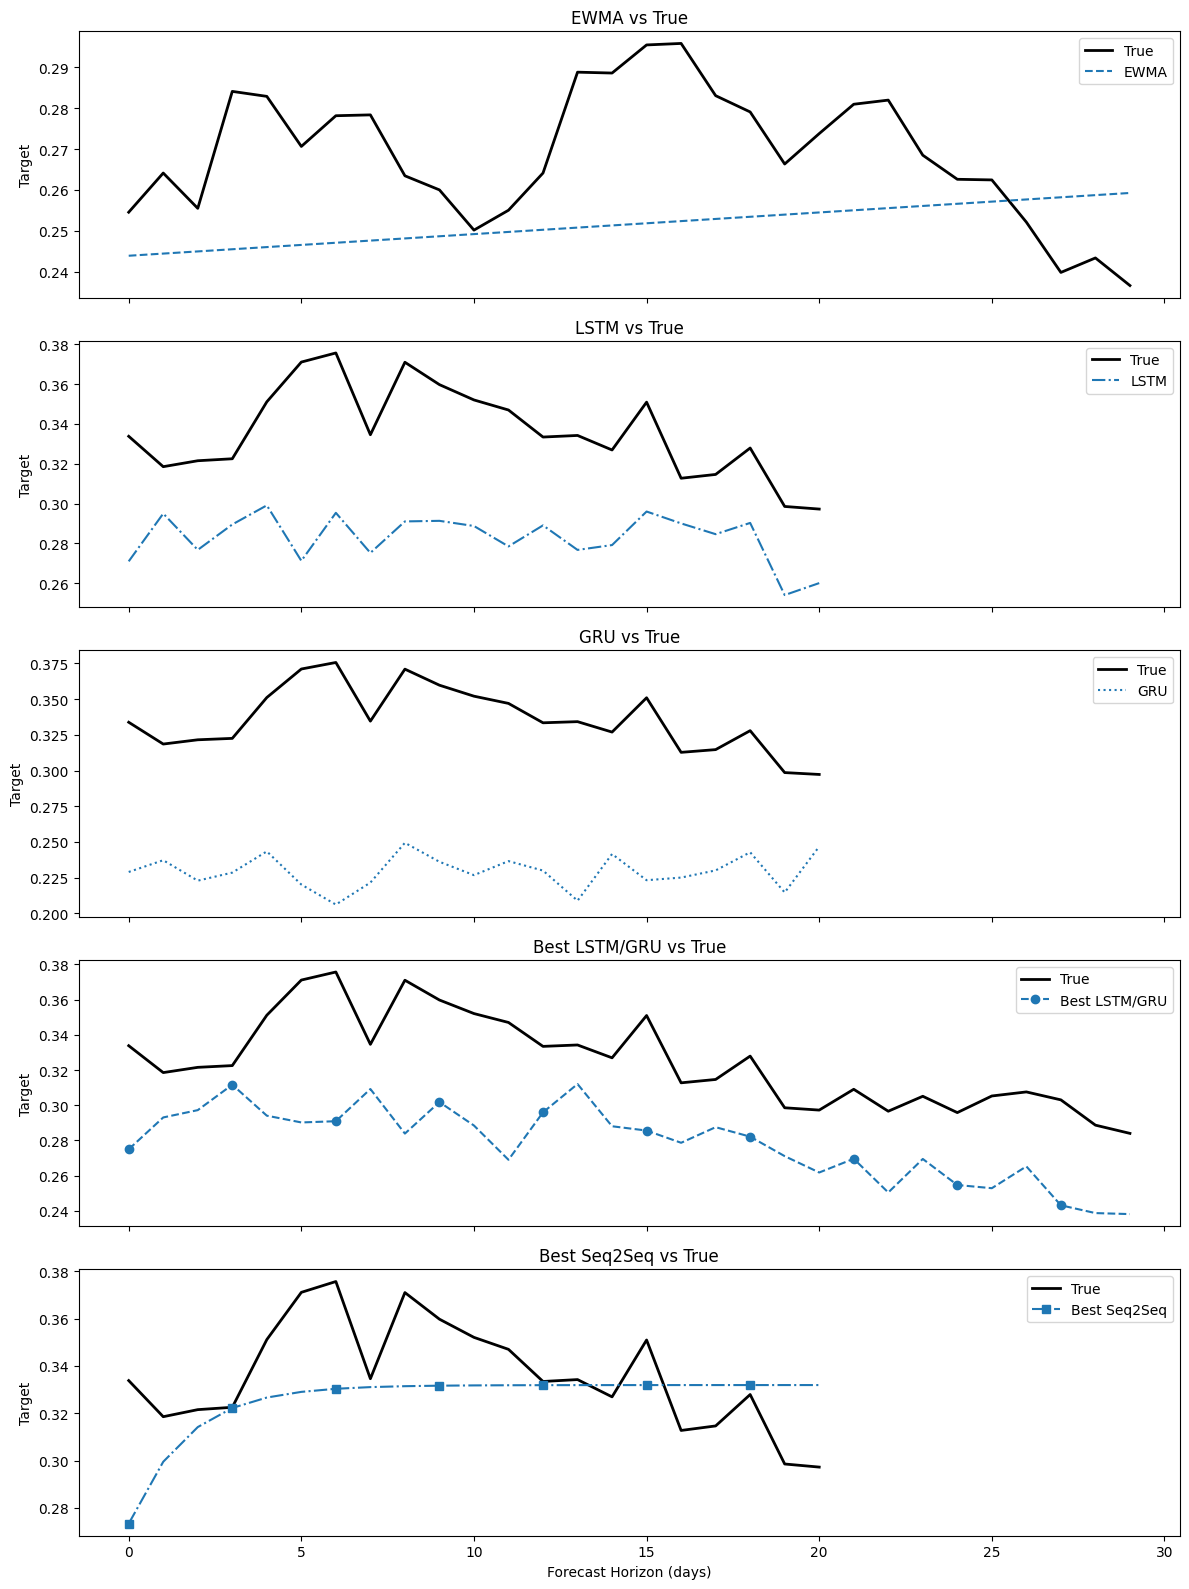

In [151]:
fig, axes = plt.subplots(5, 1, figsize=(12, 16), sharex=True)

i = 0  # test sample index

# --- EWMA ---
axes[0].plot(range(y_true_orig.shape[1]), y_true_orig[i],
             label="True", color="black", linewidth=2)
axes[0].plot(range(y_pred_ewma_orig.shape[1]), y_pred_ewma_orig[i],
             label="EWMA", linestyle="--")
axes[0].set_title("EWMA vs True")
axes[0].legend()

# --- LSTM ---
axes[1].plot(range(y_true_lstm_orig.shape[1]), y_true_lstm_orig[i],
             label="True", color="black", linewidth=2)
axes[1].plot(range(y_pred_lstm_orig.shape[1]), y_pred_lstm_orig[i],
             label="LSTM", linestyle="-.")
axes[1].set_title("LSTM vs True")
axes[1].legend()

# --- GRU ---
axes[2].plot(range(y_true_gru_orig.shape[1]), y_true_gru_orig[i],
             label="True", color="black", linewidth=2)
axes[2].plot(range(y_pred_gru_orig.shape[1]), y_pred_gru_orig[i],
             label="GRU", linestyle=":")
axes[2].set_title("GRU vs True")
axes[2].legend()

# --- Best LSTM/GRU ---
axes[3].plot(range(y_true_best_orig.shape[1]), y_true_best_orig[i],
             label="True", color="black", linewidth=2)
axes[3].plot(range(y_pred_best_orig.shape[1]), y_pred_best_orig[i],
             label="Best LSTM/GRU", linestyle="--", marker="o", markevery=3)
axes[3].set_title("Best LSTM/GRU vs True")
axes[3].legend()

# --- Best Seq2Seq ---
axes[4].plot(range(y_true_seq_best_orig.shape[1]), y_true_best_orig[i],
             label="True", color="black", linewidth=2)
axes[4].plot(range(y_pred_seq_best_orig.shape[1]), y_pred_seq_best_orig[i],
             label="Best Seq2Seq", linestyle="-.", marker="s", markevery=3)
axes[4].set_title("Best Seq2Seq vs True")
axes[4].legend()

# Common labels
for ax in axes:
    ax.set_ylabel("Target")
axes[-1].set_xlabel("Forecast Horizon (days)")

plt.tight_layout()
plt.show()


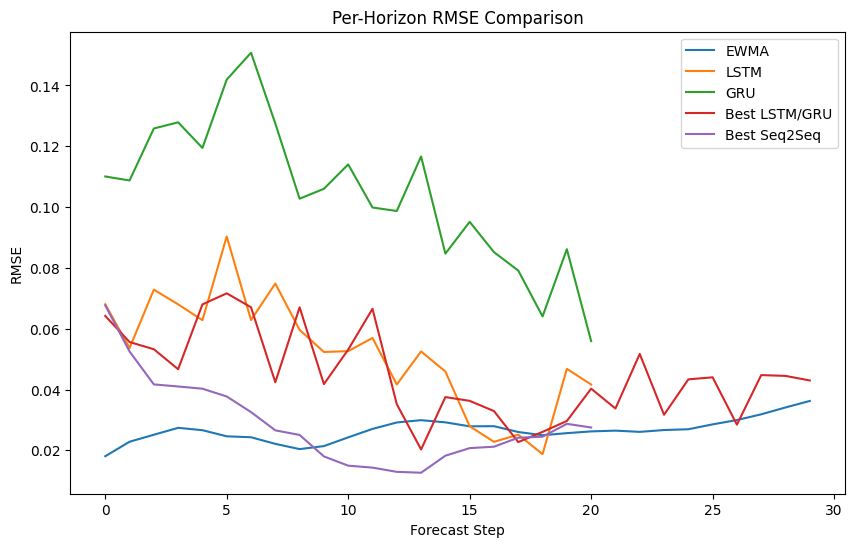

In [142]:
rmse_ewma = np.sqrt(np.mean((y_true_orig - y_pred_ewma_orig)**2, axis=0))
rmse_lstm = np.sqrt(np.mean((y_true_lstm_orig - y_pred_lstm_orig)**2, axis=0))
rmse_gru = np.sqrt(np.mean((y_true_gru_orig - y_pred_gru_orig)**2, axis=0))
rmse_best = np.sqrt(np.mean((y_true_best_orig - y_pred_best_orig)**2, axis=0))
rmse_best_seq2seq = np.sqrt(np.mean((y_true_seq_best_orig - y_pred_seq_best_orig.squeeze(-1))**2, axis=0))

plt.figure(figsize=(10,6))
plt.plot(rmse_ewma, label="EWMA")
plt.plot(rmse_lstm, label="LSTM")
plt.plot(rmse_gru, label="GRU")
plt.plot(rmse_best, label="Best LSTM/GRU")
plt.plot(rmse_best_seq2seq, label="Best Seq2Seq")
plt.xlabel("Forecast Step")
plt.ylabel("RMSE")
plt.title("Per-Horizon RMSE Comparison")
plt.legend()
plt.show()

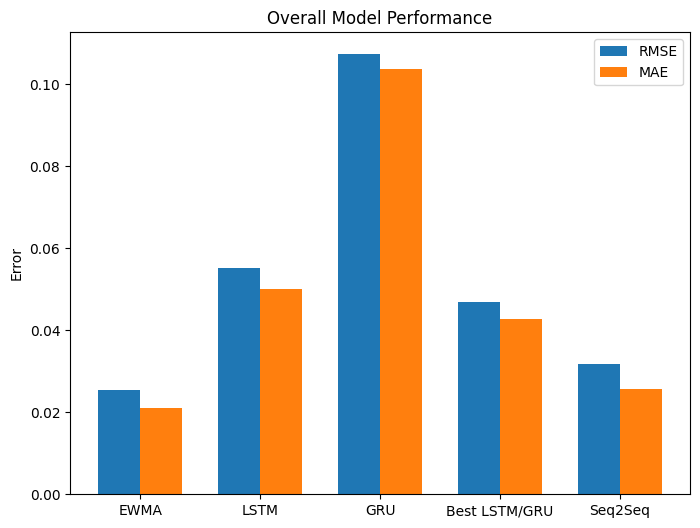

In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
    return rmse, mae

rmse_ewma, mae_ewma = get_metrics(y_true_orig, y_pred_ewma_orig)
rmse_lstm, mae_lstm = get_metrics(y_true_lstm_orig, y_pred_lstm_orig)
rmse_gru, mae_gru = get_metrics(y_true_gru_orig, y_pred_gru_orig)
rmse_best, mae_best = get_metrics(y_true_best_orig, y_pred_best_orig)
rmse_seq2seq, mae_seq2seq = get_metrics(y_true_seq_best_orig, y_pred_seq_best_orig.squeeze(-1))

labels = ["EWMA", "LSTM", "GRU", "Best LSTM/GRU", "Seq2Seq"]
rmse_vals = [rmse_ewma, rmse_lstm, rmse_gru, rmse_best, rmse_seq2seq]
mae_vals = [mae_ewma, mae_lstm, mae_gru, mae_best, mae_seq2seq]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,6))
plt.bar(x - width/2, rmse_vals, width, label="RMSE")
plt.bar(x + width/2, mae_vals, width, label="MAE")
plt.xticks(x, labels)
plt.ylabel("Error")
plt.title("Overall Model Performance")
plt.legend()
plt.show()
